# Chapter 5: Electromechanical Dynamics | Small Disturbances

#### A quick introduction the simulation of a small disturbance analysis 

Still a work in progress, if there is anything missing or you have some general feedback please contact Sjur Føyen at foyen.sjur@ntnu.no 

Outline of notebook:
- Outline

Relevant Material from TET4180 Power System Stability and Control:
1. Slides (TET4180 Power System Stability and Control | Chapter 5: Electromechanical Dynamics – Small disturbances)
2. Power System Dynamics, Machowski   (Ch. 5.1: Swing equation | Ch. 5.3: Equilibrium points (synchronising power/torque) | Ch. 5.4: Steady state stability (Linear analysis) | Ch. 5.2: Damping power (torque) | Ch. 4.2.4.4: Rotor flux dynamics)
3. Assignment 4: Electromechanical dynamics - small disturbances


Code implemented by; Varg Førland. Date; 31.01.2025

Last update; 31.01.2025

GitHub Copilot used for assistance in coding.

In [1]:
#%pip install git+https://github.com/hallvar-h/tops

import sys
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import numpy as np
from notebook_utils import getPhasorsDictionary_SmallDist

# Solver and dynamic models
from tops import dynamic as dps
from tops import solvers as dps_sol
#from tops.ps_models import ieee39

# Power System Dynamics

To effectively analyze the Power System it needs to be modeled, which is a balance act between retaining information while simplifying a complex system. First, we look at the swing equation and the relation between electrical and mechanical energy.

---

## The swing equation (chap. 5.1)

The **swing equation** is a fundamental equation in power systems that describes the dynamics of a synchronous machine's rotor. It represents the balance between the mechanical and electrical torques and how they affect the machine's angular position and speed.

- **Classic swing equation:**
    $$ J \frac{d^2\delta}{dt^2} + D_d \frac{d\delta}{dt} = \tau_m - \tau_e $$
    Where:
    - $ J $: Total moment of inertia
    - $ D_d $: Damping coefficient
    - $ \tau_m $: Mechanical torque
    - $ \tau_e $: Electromechanical torque
    - $ \delta $: Angle

This equation is derived from Newtons second law of motion as can be seen in the lecture slides. A particulary important relation which is utlized is the relation between rotational speed, or frequency, and the angle. The rotational speed can be expressed as 
$$
\omega_m = \omega_{sm} + \Delta \omega_m = \omega_{sm} + \frac{d\delta}{dt}
$$
where $\omega_sm$ is the synchronous speed, i.e. a constant $2 \pi \cdot 50Hz$. This also gives the relation 
$$
\frac{d\omega_m}{dt} = \frac{d^2\delta}{dt^2}
$$

#### Alternative expressions

The swing equation is commonly expressed in p.u. using power rather than torque, and inertia expressed in seconds. This version of the swing equation is expressed as

$$ 2 H \frac{d^2\delta}{dt^2} = P_m - P_e (\delta) - D_d \frac{d\delta}{dt} $$

---

## Equilibrium points (synchronising power/torque) (chap. 5.3)
Section 5.1 shows that the accelerating power depends on the difference between turbine power $P_m$ and electrical air-gap power $P_e$ (minus damping power $P_D$). Mechanical power is controlled by the turbine governor, while electrical air-gap power depends on generator loading, parameters, and power angle. In this section, we consider only the steady-state model of the generator-infinite busbar system, with the infinite busbar voltage $V_s$ as the reference.

In steady state, the generator is represented by a constant emf $E_q$ behind synchronous reactances $X_d$ and $X_q$. Neglecting resistances and shunt admittances, the air-gap power $P_e$ equals the power delivered to the system $P_s$ and is given by :
$$
P_e = P_{Eq} = \frac{E_q V_s}{x_d} \sin \delta + \frac{V_s^2}{2} (\frac{1}{x_q} - \frac{1}{x_d})  sin(2 \delta)
$$
in a salient pole generator. $x_d = X_d + X$, $x_q = X_q + X$, and $X = X_T + X_s$ is the combined reactance of the step-up transformer and equivalent network. The angle $\delta$ is the angle between $E_q$ and $V_s$ phasors (power angle) and the spatial angle between the generator rotor and the fictitious system generator (rotor angle). This links the swing equation with the electrical state of the generator. For constant $E_q$ and $V_s$, the power-angle characteristic $P_e = P_e(\delta)$ allows rewriting the swing equation.

If we have power with symmetry, for example in a round rotor generator where $x_d =x_q$, the expression simplifies to 
$$
P_e = P_{Eq} = \frac{E_q V_s}{x_d} \sin \delta
$$

Using these equations we can now consider the relationship between the power and power angle.

We continue with the same system as previously.


## System
A power plant is connected to an infinite grid as shown in the figure below and delivers 80 MW active power and 20 Mvar reactive power to grid. The power plant has a salient-pole generator, and the relevant parameters for the generator, transformer and transmission line are given in the table below:

![Figure1](Figures/System_Notebooks.png)

| **Category**               | **Parameter** | **Value**  | **Comment**                                                                 |
|----------------------------|---------------|------------|-----------------------------------------------------------------------------|
|                            |     | |                                                                             |
| **Generator Parameters**                          |
|   | $H$           | 5.0 seconds |                                                                             |
|                            | $D$           | 10.0 p.u.  | All per unit values are referred to $V_{\text{base}} = 132 \, \text{kV}$ and $S_{\text{base}} = 100 \, \text{MW}$ |
|                            | $X_q$         | 0.8 p.u.   |                                                                             |
|                            | $X_d$         | 1.0 p.u.   |                                                                             |
|                            | $X_d'$        | 0.3 p.u.   |                                                                             |
|                            | $T_{d0}'$     | 7.0 seconds |                                                                             |
|                            |  
|   **Transformer**                                                             |
|  | $X_t$         | 0.1 p.u.   | Nominal voltages: 17/132 kV, referred to $S_{\text{base}} = 100 \, \text{MW}$ |
|                            |  
|  **Transmission Line**                               |     | |                                                                             |
|  | $X_l$         | 0.1 p.u.   | Referred to $V_{\text{base}} = 132 \, \text{kV}$ and $S_{\text{base}} = 100 \, \text{MW}$ |
|                            |     | |                                                                             |



In [2]:
# System data Definitions:
# Base data
Sb = 100 # MVA
Vb_lv = 10 # kV
Vb_hv = 132 # kV
# pu conversion
Vs_kV = 132 + 0j # kV < deg
Vs = Vs_kV / Vb_hv # pu
P_MW = 80 # MW delivered power to network 
Q_MVAR = 20 #MVAR delivered power to network
P = P_MW / Sb # pu
Q = Q_MVAR / Sb # pu

#Transformer data
Xt =  0.1 # pu

#Generator data
H = 5 # s
D = 10 # pu
Xq = 0.8 # pu
Xd = 1.0 # pu
Xd_t = 0.3 # pu (_t means transient) (_st means subtransient)
Td0_t = 7.0 # s

#Line data
Xl = 0.1 # pu

xq = Xq + Xt + Xl
xd = Xd + Xt + Xl
xd_t = Xd_t + Xt + Xl

# Function which calculates the phasors for the generator model - Same as in notebook 2
phasors = getPhasorsDictionary_SmallDist(P, Q, Vs, Xq, Xd, Xd_t, Xt, Xl)

Eq = phasors['Eq']
Eq_t = phasors['Eq_t']
delta = np.angle(Eq)

print("From calculation / previous notebook:")
display(Math(r'Eq = {0:.4f} \angle {1:.2f}^\circ'.format(abs(Eq), np.angle(Eq)*180/np.pi)))
display(Math(r'Eqt = {0:.4f} \angle {1:.2f}^\circ'.format(abs(Eq_t), np.angle(Eq_t)*180/np.pi)))
display(Math(r'\delta = {0:.2f}^\circ'.format(delta*180/np.pi)))


From calculation / previous notebook:


NameError: name 'Math' is not defined

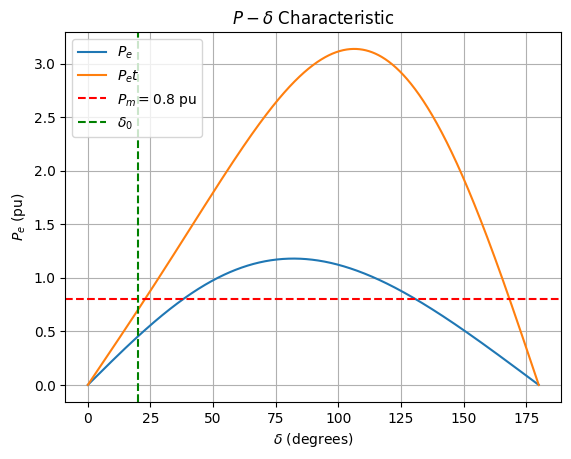

In [ ]:
P_m = 0.8  # Mechanical power in pu

E_q_mag = abs(Eq)  # Constant emf behind synchronous reactance
E_q_mag_t = abs(Eq_t)  # Constant emf behind transient reactance
Vs_mag = abs(Vs)  # Magnitude of the stator voltage

# Delta values from 0 to pi
delta = np.linspace(0, np.pi, 1000)
delta_deg = np.degrees(delta)

# Power-angle characteristic
P_e = (E_q_mag * Vs_mag / xd) * np.sin(delta) + Vs_mag ** 2 / 2 * (1/xq - 1/xd) * np.sin(2 * delta)
P_et = (E_q_mag_t * Vs_mag / xd_t) * np.sin(delta) + Vs_mag ** 2 / 2 * (1/xq - 1/xd_t) * np.sin(2 * delta)

# Plotting
delta_0 = np.degrees(np.angle(Eq))  # Calculate delta_0 in degrees

plt.figure()
plt.plot(delta_deg, P_e, label='$P_e$')
plt.plot(delta_deg, P_et, label='$P_et$')
plt.xlabel(r'$\delta$ (degrees)')
plt.ylabel(r'$P_e$ (pu)')
plt.title(r'$P-\delta$ Characteristic')
plt.grid(True)
plt.axhline(y=P_m, color='r', linestyle='--', label=r'$P_m = 0.8$ pu')
plt.axvline(x=delta_0, color='g', linestyle='--', label=r'$\delta_0$')
plt.legend()
plt.show()

## Stability criterion $K_E$

One way to assess the small signal stability of the system is the $K_E$ criterion. This is done by linearizing and assessing the rate of change in the operating point. We formulate this as
- $K_E = $